In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

In [20]:
x=pd.read_csv("X.csv")
y=pd.read_csv("Y.csv")

#eliminating empty labeled rows

In [21]:
rifX=x
rifY=y["RIF"]
rif=pd.concat([rifX,rifY],axis=1)
indices=rif[rif["RIF"]==-1].index
rifFiltered=rif.drop(indices)

# X and Y after data is preprocessed
rifX=rifFiltered.iloc[:,0:222]
rifY=rifFiltered["RIF"]

# finding imbalance

1    2057
0    1278
Name: RIF, dtype: int64


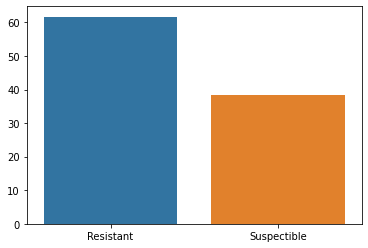

In [22]:
counts=rifFiltered['RIF'].value_counts()
print(counts)
proportions = counts / counts.sum()
proportions=proportions*100
sns.barplot(x=["Resistant","Suspectible"],y=proportions.values)
plt.show()

In [23]:
rifX_train,rifX_test,rifY_train,rifY_test=train_test_split(rifX,rifY,test_size=0.2,random_state=21)

# parameter tuning for random forest

In [25]:
model1=RandomForestClassifier()
param_grid = {
    'n_estimators': [30,50, 100],
    'max_depth': [None, 5, 10],
}
grid_search = GridSearchCV(model1, param_grid=param_grid, cv=5, n_jobs=-1,scoring='roc_auc')
grid_search.fit(rifX, rifY)
print(grid_search.best_params_)

{'max_depth': 5, 'n_estimators': 50}


# parameter tuning for svm

In [26]:
model2=svm.SVC()
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(model2, param_grid, refit=True, verbose=0, cv=5,scoring='roc_auc')
grid_search.fit(rifX, rifY)
print(grid_search.best_params_)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}


# parameter tuning for logistic regression

In [51]:
# model3=LogisticRegression()
# param_grid = {'C': [ 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}
# grid_search = GridSearchCV(model3, param_grid=param_grid,cv=5,verbose=0)
# grid_search.fit(rifX, rifY)
# print(grid_search.best_params_)

# parameter tuning for BernoulliNB

In [27]:
model4=BernoulliNB()
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(model4, param_grid=param_grid, cv=5,scoring='roc_auc')
grid_search.fit(rifX, rifY)
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'alpha': 10}


# model1 (random forest)

Random forest
--------------------
accuracy  0.9130434782608695
f1_score  0.9276807980049875
auc  0.9176548089591567
precision  0.9587628865979382
sensitivity  0.8985507246376812
specificity  0.10144927536231885


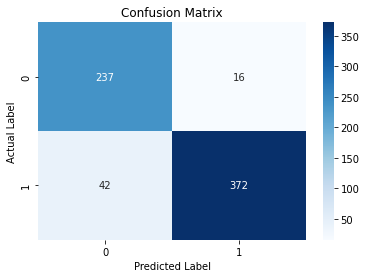

In [29]:
rifModel1=RandomForestClassifier(n_estimators=50,max_depth=5)
rifModel1.fit(rifX_train,rifY_train)
rifPred=rifModel1.predict(rifX_test)
print("Random forest")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model 2 (svm)

SVM
--------------------
accuracy  0.9760119940029985
f1_score  0.9807692307692307
auc  0.9729907773386034
precision  0.9760765550239234
sensitivity  0.9855072463768116
specificity  0.01449275362318836


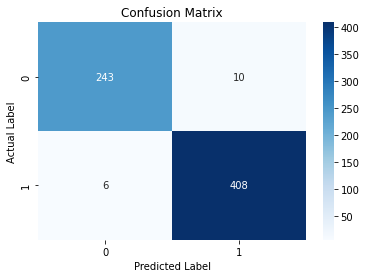

In [30]:
rifModel2=svm.SVC(kernel="linear",C= 0.1, gamma= 0.1)
rifModel2.fit(rifX_train,rifY_train)
rifPred=rifModel2.predict(rifX_test)
print("SVM")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model 3 (Logistic regression)

Logistic Regression
--------------------
accuracy  0.9685157421289355
f1_score  0.9748502994011977
auc  0.9638779095300833
precision  0.9667458432304038
sensitivity  0.9830917874396136
specificity  0.016908212560386437


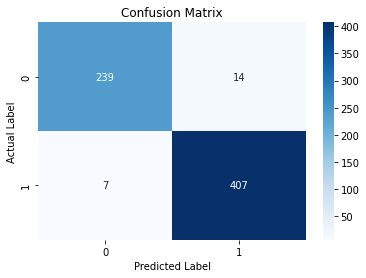

In [58]:
rifModel3=LogisticRegression()
rifModel3.fit(rifX_train,rifY_train)
rifPred=rifModel3.predict(rifX_test)
print("Logistic Regression")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# model4 (bernoulliNB)


BernoulliNB
--------------------
accuracy  0.9055472263868066
f1_score  0.9219330855018587
auc  0.9077733860342556
precision  0.9465648854961832
sensitivity  0.8985507246376812
specificity  0.10144927536231885


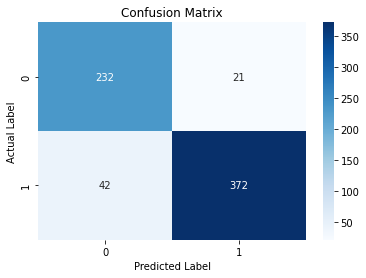

In [31]:
rifModel4=BernoulliNB(alpha=10)
rifModel4.fit(rifX_train,rifY_train)
rifPred=rifModel4.predict(rifX_test)
print("BernoulliNB")
print("--------------------")
print("accuracy ", accuracy_score(rifY_test,rifPred))
print("f1_score ", f1_score(rifY_test,rifPred))
print("auc ", roc_auc_score(rifY_test,rifPred))
print("precision ",precision_score(rifY_test,rifPred))
print("sensitivity ",recall_score(rifY_test,rifPred))
print("specificity ",1-recall_score(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
cm=(confusion_matrix(rifY_test,rifPred))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# evaluating using cross_validation_score with folds=30

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
print("Random Forest")
aucScores=cross_val_score(rifModel1, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel1, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())

Random Forest
Mean f1_score  0.8813079463644358
Mean auc  0.9891725648803503


In [34]:
print("SVM")
aucScores=cross_val_score(rifModel2, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel2, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())

SVM
Mean f1_score  0.9548208093221723
Mean auc  0.9920520685523956


In [59]:
print("Logistic Regression")
aucScores=cross_val_score(rifModel3, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel3, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())
# print(aucScores)

Logistic Regression
Mean f1_score  0.9524878935833759
Mean auc  0.9923538553720557


In [35]:
print("BernoulliNB")
aucScores=cross_val_score(rifModel4, rifX, rifY, cv=30, scoring="roc_auc")
f1Scores = cross_val_score(rifModel4, rifX, rifY, cv=30, scoring='f1')
print("Mean f1_score ",f1Scores.mean())
print("Mean auc ",aucScores.mean())
# print(aucScores)

BernoulliNB
Mean f1_score  0.8802079802946542
Mean auc  0.9632356717543774
